# [E-11] 주식시장 예측 
여러가지 통계적 기법에 대해 공부해보기 위해 주식 종목의 가격을 예측해보는 실습을 진행한다. 

학습목표
- 시계열 데이터의 특성과 안정적 시계열의 개념 이해
- ARIMA 모델을 구성하는 AR, MA, Diffrencing의 개념 이해 및 시계열 데이터에 적용
- 실제 주식 데이터에 AIRMA 적용해서 예측 정확도 확인

## 1. 라이브러리 import, 데이터 로드 - Apple의 market price

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
2021-02-23    125.860001
Name: Close, dtype: float64

## 2. 결측치 처리 및 로그 변환

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)

## 3. 시계열 안정성 분석

### 정성적 그래프 분석

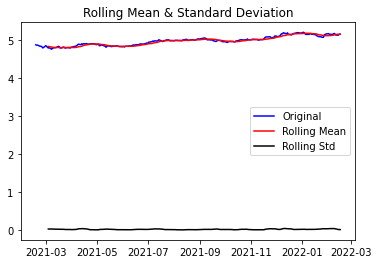

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

### 정량적 Agmented Dicky-Fuller Test

In [5]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey-Fuller Test:
Test Statistic                  -0.690251
p-value                          0.849259
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


p-value값이 0.84로 귀무가설과 대립가설의 채택 기준치인 0.05보다 높으므로 귀무가설이 채택된다. 따라서 이 시계열 데이터는 안정적이지 않은 데이터라는 결론을 얻을 수 있다. 주식 가격의 정확한 예측을 위해 시계열 데이터를 더욱 안정적으로 만들어 p-value 값을 낮추어야 한다. 이를 위해 시계열 데이터를 4가지 기준(original, 추세, 계절성, 불규칙요소)로 분해하여 분석한다. 

### 시계열 분해

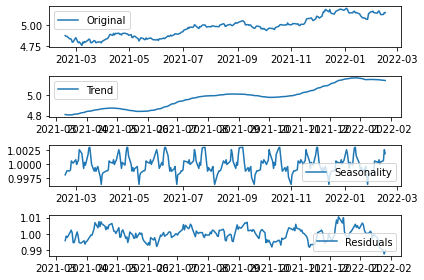

In [6]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 시계열의 안정성 확인

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.449081
p-value                          0.000243
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


p-value 값이 0.05 이하로 떨어졌으므로 귀무가설은 기각되고 대립가설이 채택된다. 따라서 시계열 데이터의 안정성이 확보되었고 모델의 안정적 예측을 위한 데이터셋으로 사용할 수 있는 근거가 된다. 


## 4. 학습, 테스트 데이터셋 생성

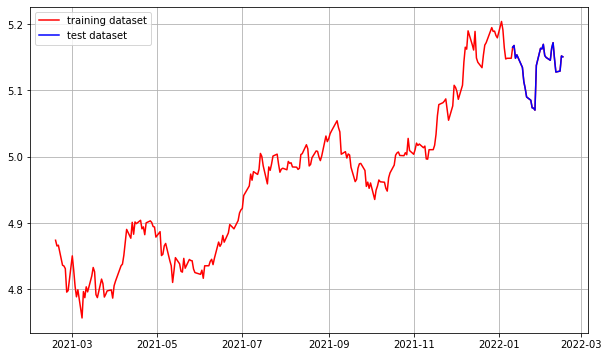

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

### ACF, PACF 그려보기

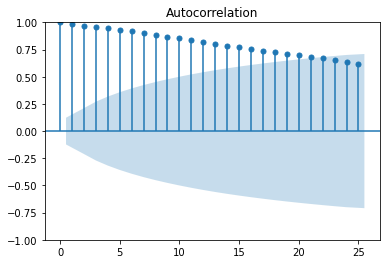

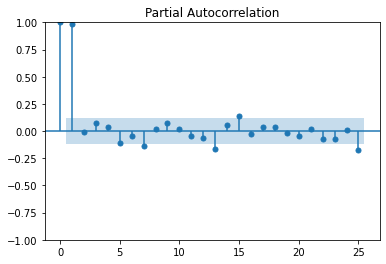

In [11]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위 그래프를 통해 ARIMA 모델의 모수 값을 구한다. ACF 그래프를 통해 MA모델의 시차 q를 결정할 수 있고, PACF 그래프를 통해 AR모델의 시차 p를 결정할 수 있다. ACF 그래프 값이 점차 감소하고 있기 때문에 적절한 q값이 보이지 않는다. 그러나 PACF 그래프상 p가 2 이상인 구간부터 PACF는 0에 가깝게 형성이 되어있다. 즉, 데이터 상관도가 0에 수렴하므로 AR 모델의 p=1이 적절함을 알 수 있다. 

### 차분 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.613159e+01
p-value                        4.778989e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.700936e+00
p-value                        1.339935e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


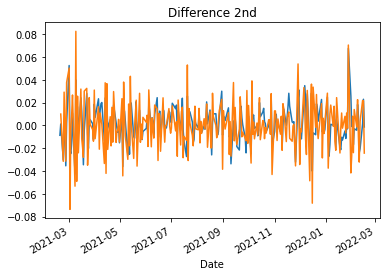

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [16]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 628.317
Date:                Thu, 17 Feb 2022   AIC                          -1252.633
Time:                        14:06:02   BIC                          -1245.784
Sample:                             0   HQIC                         -1249.869
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0637      0.063     -1.004      0.316      -0.188       0.061
sigma2         0.0002   1.98e-05     11.682      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


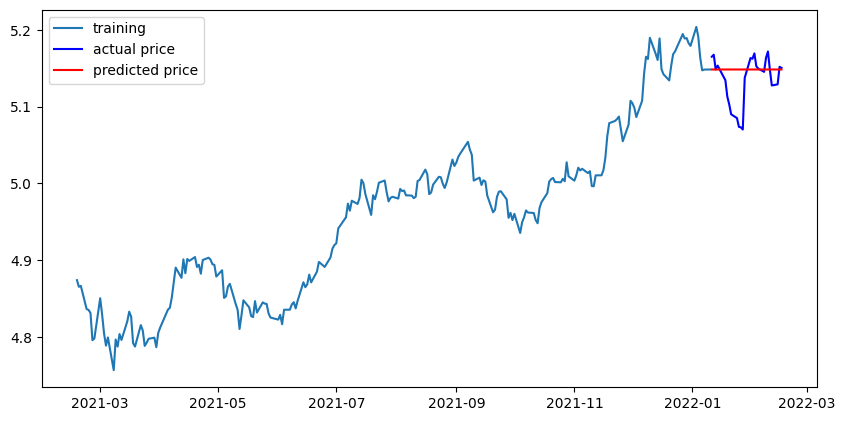

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


### 최종 예측 모델 정확도 측정

In [18]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  34.00506490940173
MAE:  4.151925684330013
RMSE:  5.831386191069987
MAPE: 2.51%


# 후기


전체적으로 노드를 진행하며 학습했다는 느낌을 받지 못했다. 왜냐하면 통계적 개념에 대해 아는것이 없었기에 노드에 설명된 개념을 읽어도 통계용어가 어떤 의미를 지녔는지 알 수가 없어 대부분 이해하지 못하고 우선 받아들이며 진행하여야 했다. 따라서 이번 장을 배우며 얻은 후기를 남기는 것 보단 내가 무엇을 더욱 모르게 되었는지 정리하는것이 나을것이라 생각한다. 

학습을 진행하며 이해가 가지 않았던 점 

- 여러가지 통계학 개념 : 분산, 공분산, 상관계수, 자기공분산, 자기상관계수에 대한 이해와 응용
- 귀무가설과 대립가설의 근거를 세우기 위한 모델링의 원리
- ARIMA 모델의 수학적 원리와 모수의 활용, 모수를 도출하는 근거

루브릭 상에서 3가지 주식가격에 대한 예측을 요구했으나 근거와 원리를 제대로 이해하지 못하고 나오는 결과를 받아들이는 것이 내키지 않아서 개념부터 이해를 하고싶었고 결국 시간 부족으로 제대로 이해도 못하고 시도도 하지 못했다. 